In [1]:
import torch
import numpy as np
import mediapy
import pickle
from scipy.io import savemat
import argparse
from tqdm import tqdm
from auxiliar.tracking_viz import generate_frame_image_cv
from src.new_queries import add_new_tracks

import matplotlib.pyplot as plt
from src.factorization import marques_factorization
import rerun as rr
from src.mat_compl import alternating_matrix_completion

%load_ext autoreload
%autoreload 2

# add tapnext to pythonpath
import sys
sys.path.append("/home/manuelf/tapnet")
from tapnet.tapnext.tapnext_torch import TAPNext # type: ignore
from tapnet.tapnext.tapnext_torch_utils import restore_model_from_jax_checkpoint # type: ignore

def init_tapnext(device):

  tapnext = TAPNext(image_size=(256, 256)).to(device)

  #set model to eval, not backprop
  tapnext.eval()
  for p in tapnext.parameters():
    p.requires_grad = False

  tapnext = restore_model_from_jax_checkpoint(tapnext, "/home/manuelf/tapnet/tapnet/tapnext/tapnet/checkpoints/bootstapnext_ckpt.npz")

  return tapnext

/home/manuelf/miniconda3/envs/trackers/lib/python3.11/site-packages/torch/_export/utils.py:415: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _register_pytree_node(


In [2]:
import cv2 as cv
from auxiliar.read_video import read_video_or_images

model_video_size = (256, 256)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda:1"

path = "../mast3r/images_in/casa_bea_4_photos/"
#video_resized, video = read_video_or_images("../mast3r/images_in/bordalo.mp4",model_video_size, device)
video_resized, video = read_video_or_images(path,model_video_size, device)

tapnext = init_tapnext(device)

torch.cuda.empty_cache()

In [4]:

# Design the query points array in the original video size
step = 30
ys, xs = np.meshgrid(np.linspace(8, video[0].shape[0]-step, step), np.linspace(8, video[0].shape[1]-step, step))
query_points_initial = torch.tensor(
    np.stack(
    [np.zeros(len(xs.flatten())), xs.flatten(), ys.flatten()], axis=1
)[None],dtype=torch.float32).to(device)

#write text with opencv
if 1:
    im = cv.resize( cv.cvtColor(np.array((video[0]+1)/2*255).copy().astype(np.uint8), cv.COLOR_RGB2BGR), 
               tuple(np.flip(np.array(video[0].shape[0:2]))*5) ) # Copy the first frame for visualization

    for i in range(query_points_initial.shape[1]):
        im = cv.putText(img=im, text=str(i), org=(int(query_points_initial[0, i, 1].item()*5), int(query_points_initial[0, i, 2].item()*5)),
                        fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        
    cv.imwrite("query_points_initial.png", im)

#resize the querys points to the model size
query_points_initial[0, :, 1:3] /= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]]).to(device)

#creata tensors for the video information
frame_cut = 7
video_tensor_original = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video]).unsqueeze(0)[:,0:frame_cut,...] # 1, time, H, W, 3
video_tensor_resized = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video_resized]).unsqueeze(0)[:,0:frame_cut,...].to(device) # 1, time, H, W, 3

/tmp/ipykernel_18347/899351100.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im = cv.resize( cv.cvtColor(np.array((video[0]+1)/2*255).copy().astype(np.uint8), cv.COLOR_RGB2BGR),
/tmp/ipykernel_18347/899351100.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  video_tensor_original = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video]).unsqueeze(0)[:,0:frame_cut,...] # 1, time, H, W, 3
/tmp/ipykernel_18347/899351100.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

In [5]:

# INFERENCE
next_track_id = 0  # unique ID for every track
track_histories = {}  # track_id -> list of (frame_index, (x, y)) or None
active_tracks = {}  # current_idx -> track_id (used during current step)

with torch.no_grad():
  with torch.amp.autocast('cuda', dtype=torch.float32, enabled=True):
    
    tracks, tracks_logits, visible_logits, tracking_state = tapnext(video=video_tensor_resized[:, :1], query_points=query_points_initial)

    num_feats = tracks.shape[2]
    for i in range(num_feats):
        track_id = next_track_id
        next_track_id += 1
        active_tracks[i] = track_id
        track_histories[track_id] = [(0, tracks[0, 0, i, :2].cpu())]  # frame 0 position

    for k in tqdm(range(1, video_tensor_resized.shape[1])):

        tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
            video=video_tensor_resized[:, k:k + 1],
            state=tracking_state)
        
        # trakcs_step sai sempre bem 

        visible = (visible_logits_step.squeeze() > 0).cpu()
        for i, track_tensor in enumerate(tracks_step[0, 0]):
            track_id = active_tracks.get(i, None)
            if track_id is not None:
                if visible[i]:
                    track_histories[track_id].append((k, track_tensor[:2].cpu()))
                else:
                    track_histories[track_id].append((k, None))  # Not visible

        # New feature detection
        new_tracks = add_new_tracks(tracks_step, query_points_initial)
        
        if 0:
        #if new_tracks is not None and new_tracks.shape[1] > 120:
            print(f"Adding new tracks: {new_tracks.shape[1]}")

            new_tracks[0, :, 0] = 0  # set time to 0 for tapnext reinit

            # retain visible active tracks from previous step
            retained_indices = [i for i, v in enumerate(visible) if v]
            retained_ids = [active_tracks[i] for i in retained_indices]

            retained_tracks = tracks_step[0, 0, retained_indices].unsqueeze(0)
            zero_time = torch.zeros((1, len(retained_indices), 1)).to(retained_tracks.device)
            retained_tracks = torch.cat([zero_time, retained_tracks], dim=2)

            concat_tracks = torch.cat([retained_tracks, new_tracks.to(device)], dim=1)

            tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
                video=video_tensor_resized[:, k].unsqueeze(0),
                query_points=concat_tracks)

            # update active_tracks dict
            active_tracks = {}
            for i, id in enumerate(retained_ids):
                active_tracks[i] = id  # preserve old IDs

            new_start = len(retained_ids)
            visible = (visible_logits_step.squeeze() > 0).cpu()
            for i in range(new_tracks.shape[1]):
                track_id = next_track_id
                next_track_id += 1
                active_tracks[new_start + i] = track_id
                if visible[new_start + i]:
                    # Only add if the new track is visible
                    track_histories[track_id] = [(k, tracks_step[0, 0, new_start + i, :2].cpu())]
                else:
                    track_histories[track_id] = [(k, None)]

100%|██████████| 5/5 [00:01<00:00,  4.48it/s]


In [6]:
num_frames = video_tensor_resized.shape[1]
output = {}

for track_id, trajectory in tqdm(track_histories.items()):
    coords = []
    for t in range(num_frames):
        step = next((pos for (frame, pos) in trajectory if frame == t), None)
        coords.append(step if step is not None else torch.tensor([float('nan'), float('nan')]))
    output[track_id] = torch.stack(coords)  # shape: [num_frames, 2]

output_list = [trajectory.unsqueeze(0) for _, trajectory in output.items()]
output_tensor = torch.cat(output_list, dim=0).unsqueeze(0).permute(0,2,1,3)  # shape: [1 , num_frames, num_feats, 2]

output_tensor = output_tensor[:,:,:,[1,0]]
output_tensor[:, : ,:,  :] *= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]])

  0%|          | 0/900 [00:00<?, ?it/s]

100%|██████████| 900/900 [00:00<00:00, 43742.81it/s]


In [7]:

frame_cut_out = output_tensor.shape[1]
#
# frame_cut_out = 120

# Calculate the number of visible frames for each track
visible_counts = torch.sum(~torch.isnan(output_tensor[0, :frame_cut_out, :, 0]), dim=0)

# Filter tracks that are visible for at least 20 frames
visible_tracks_mask = visible_counts >= 1
output_tensor_filtered = output_tensor[:, :frame_cut_out, visible_tracks_mask, :]
output_tensor_filtered.shape

torch.cuda.empty_cache()

In [8]:
generate_frame_image_cv(video_tensor_original, output_tensor)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


In [9]:
import torch.nn.functional as F

def get_rgb_at_coords_torch(image_tensor, xy_coords):
    """
    image_tensor: (3, H, W) float32 torch tensor, range [0,1]
    xy_coords: (N, 2) tensor of (x, y) coordinates in pixel space
    Returns:
        rgb: (N, 3) interpolated RGB values
    """
    C, H, W = image_tensor.shape
    image_tensor = image_tensor.unsqueeze(0)  # (1, 3, H, W)

    # Normalize coords to [-1, 1]
    x = 2 * xy_coords[:, 0] / (W - 1) - 1
    y = 2 * xy_coords[:, 1] / (H - 1) - 1
    grid = torch.stack([x, y], dim=1).view(1, -1, 1, 2)  # (1, N, 1, 2)

    sampled = F.grid_sample(image_tensor, grid, mode='bilinear', align_corners=True)
    rgb = sampled[0, :, :, 0].T  # shape (N, 3)
    return rgb

Percentage of missing values: 24.62%


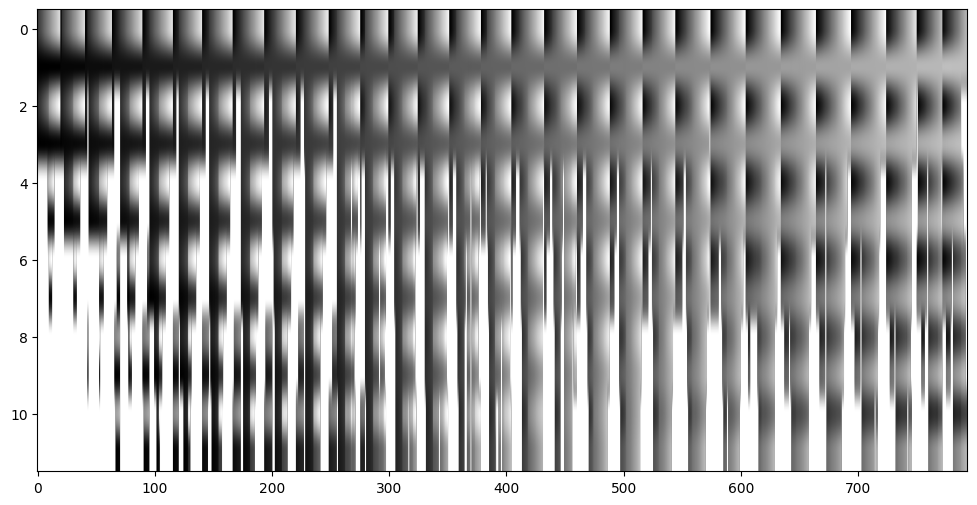

In [10]:
# Reshape the output_tensor to create the observation matrix
# Shape of output_tensor: [1, num_frames, num_feats, 2]
# Desired shape of observation_matrix: [feats*2, frames]

# todo: comparar alucinacoes cotracker

obs_mat_full = np.zeros((output_tensor_filtered.shape[1] * 2, output_tensor_filtered.shape[2]), dtype=np.float32)
num_frames = output_tensor_filtered.shape[1]

for frame in range(output_tensor_filtered.shape[1]): # por frame
    obs_mat_full[frame*2, :] = output_tensor_filtered[0, frame, :, 0].cpu().numpy()  # x-coordinates
    obs_mat_full[frame*2+1, :] = output_tensor_filtered[0, frame, :, 1].cpu().numpy()  # y-coordinates

#remove columns (features) that have nan values
obs_mat = obs_mat_full[:, ~np.isnan(obs_mat_full).any(axis=0)]

# remove collumns that have more than 50% nan values
# Create a mask for columns with less than 50% NaN values
valid_columns_mask = np.sum(np.isnan(obs_mat_full), axis=0) < obs_mat_full.shape[0] / 1.3

# Apply the mask to filter columns
obs_mat_half_missed = obs_mat_full[:, valid_columns_mask]


# go by featyre in obs_mat_full and chekck the first time that a certain feature appears
for f in range(obs_mat_half_missed.shape[1]): #feature
    first_appearance = np.where(~np.isnan(obs_mat_half_missed[:, f]))[0] // 2
    
    if first_appearance.size > 0:
        #print(f"Feature {f} first appears at frame {first_appearance[0]}")

        rgb_value = get_rgb_at_coords_torch(video_tensor_original[0, first_appearance[0]].permute(2, 0, 1), # the frame at which the feature first appears
                                             torch.tensor(obs_mat_half_missed[first_appearance[0]*2:first_appearance[0]*2+2, f]).unsqueeze(0)) * 255
        
        #print(f"Feature {f} first appears at frame {first_appearance[0]} with RGB value {rgb_value.cpu().numpy()}, \
        #       in {obs_mat_half_missed[first_appearance[0]*2:first_appearance[0]*2+2, f]}")




# Store the original indices of the valid columns for tracking
#original_indices = np.where(valid_columns_mask)[0]

#print the percentage of missing values
missing_percentage = np.sum(np.isnan(obs_mat_half_missed)) / (obs_mat_half_missed.shape[0] * obs_mat_half_missed.shape[1]) * 100
print(f"Percentage of missing values: {missing_percentage:.2f}%")


plt.figure(figsize=(12, 6))
plt.imshow(obs_mat_half_missed/np.nanmax(obs_mat_half_missed), aspect='auto', cmap='gray')
#plt.imshow(obs_mat/np.nanmax(obs_mat_half_missed), aspect='auto', cmap='gray', alpha=0.5)


  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:07, 23.16it/s, RMSE=96.250350952148]


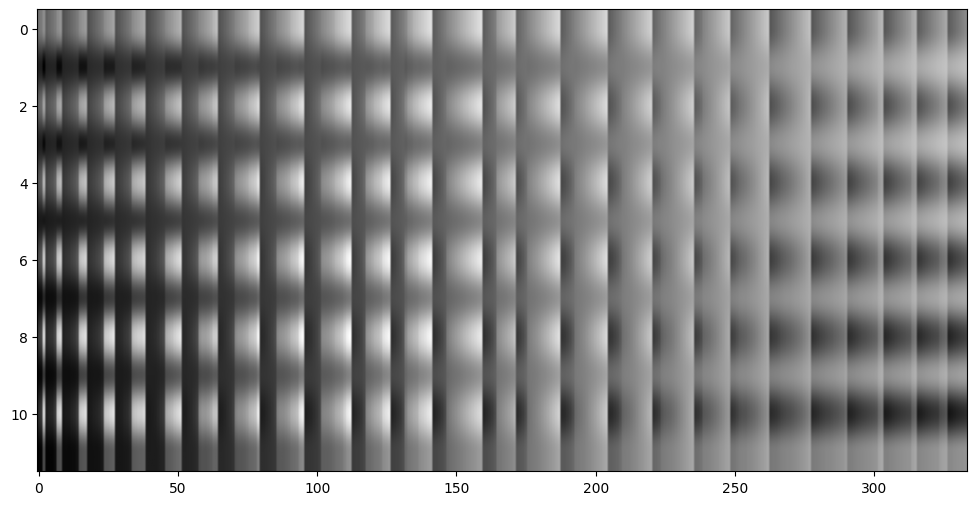

In [11]:
obs_completed, _ = alternating_matrix_completion(obs_mat, mode=0, max_iters=200, rank=3)

plt.figure(figsize=(12, 6))
plt.imshow(obs_completed/np.nanmax(obs_completed), aspect='auto', cmap='gray')


In [96]:

rr.init("factorization")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))

rr.log("world/3d_completed", rr.Points3D(shape.T))

# TODO: ADD COLOR TO EACH POINT


Viewer()

In [95]:
# testing costeira marques
from src.factorization import costeira_marques
import torch.nn.functional as F

def rgba_to_rgba32(r, g, b, a):
    """Convert RGBA (0 - 255 range) to Rerun's Rgba32 format."""
    return (r << 24) | (g << 16) | (b << 8) | a

# completion + factorization
motion, shape, t = costeira_marques(obs_mat_resized, iterMax1=100, iterMax2=100,stopError1=1e-2, stopError2=1e-5) # rank 3
reconstructed_obs = motion @ shape + t.repeat(1, shape.shape[1])


Outer Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Outer Iterations: 100%|██████████| 100/100 [00:02<00:00, 47.21it/s]


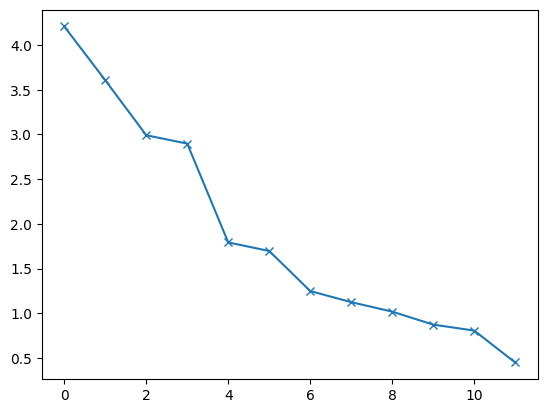

In [98]:
#plt.imshow(reconstructed_obs.numpy(), cmap='gray', aspect='auto')
plt.plot(torch.log10(torch.linalg.svd(obs_mat_resized).S).numpy(),"-x")

In [17]:
import grpc
import os
import sys
import json

sys.path.append('../boxes/vggt/protos')
import pipeline_pb2 as vggt_pb2
import pipeline_pb2_grpc as vggt_pb2_grpc
from aux import wrap_value, unwrap_value

image_byte_list = []
# List all files in the directory
files = [os.path.join(path, file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]

for file in files:
    # Open the file in binary read mode ('rb') and read its entire content
    with open(file, 'rb') as f:
        image_bytes = f.read()
        image_byte_list.append(image_bytes)
        print(f"Read {file}: {len(image_bytes) / (1024 * 1024):.2f} MB")


config_json = {

    "aispgradio": {
        "command": "3d_infer",
        "parameters": {
            "device": "cuda:0", # TODO: implement this
            "conf_vis": 50.0
        }
    }
}
request = vggt_pb2.Envelope(data={"images":wrap_value(image_byte_list)},
                            config_json = json.dumps(config_json))
channel_opt = [('grpc.max_send_message_length', -1), ('grpc.max_receive_message_length', -1)]
channel=grpc.insecure_channel("localhost:8061",options=channel_opt)
estimator_stub = vggt_pb2_grpc.PipelineServiceStub(channel)
response = estimator_stub.Process(request)
channel.close()

#write the glb as a file
glb_file = unwrap_value(response.data["glb_file"])
with open("output.glb", "wb") as f:
    f.write(glb_file)


Read ../mast3r/images_in/casa_bea_4_photos/4.jpg: 0.89 MB
Read ../mast3r/images_in/casa_bea_4_photos/2.jpg: 0.63 MB
Read ../mast3r/images_in/casa_bea_4_photos/3.jpg: 0.82 MB
Read ../mast3r/images_in/casa_bea_4_photos/6.jpg: 0.74 MB
Read ../mast3r/images_in/casa_bea_4_photos/5.jpg: 1.62 MB
Read ../mast3r/images_in/casa_bea_4_photos/1.jpg: 1.00 MB


In [ ]:
rr.init("3d_vggt")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))

import io
wrld_pts = torch.load(io.BytesIO(unwrap_value(response.data["world_points"]))).squeeze().numpy().reshape(-1,3)
wrld_conf = torch.load(io.BytesIO(unwrap_value(response.data["world_points_conf"]))).squeeze().numpy().reshape(-1,1)

rr.log("world/3d_completed", rr.Points3D(
    wrld_pts[wrld_conf.flatten() > 4, :]))



In [52]:
import torch
import torch.nn.functional as F

def sample_depths(depths, tracks):
    """
    depths: [F, H, W]  depth maps
    tracks: [2F, P]    pixel coords (u,v)
    Returns: [F, P] sampled depths
    """
    F_, H, W = depths.shape
    P = tracks.shape[1]

    depths = depths.unsqueeze(1)  # [F, 1, H, W]

    all_depths = []
    for f in range(F_):
        u = tracks[2*f, :]   # [P]
        v = tracks[2*f+1, :] # [P]

        # Normalize coords to [-1,1] for grid_sample
        u_norm = (u / (W-1)) * 2 - 1
        v_norm = (v / (H-1)) * 2 - 1
        grid = torch.stack([u_norm, v_norm], dim=-1).view(1, P, 1, 2)  # [1,P,1,2]

        z = F.grid_sample(
            depths[f:f+1], grid, align_corners=True, mode='bilinear'
        ).view(-1)  # [P]

        all_depths.append(z)

    return torch.stack(all_depths, dim=0)  # [F, P]

import torch

def build_depth_weighted_matrix(tracks, depths, fx, fy, cx, cy):
    """
    Build a 3F x P depth-weighted observation matrix.

    Args:
        tracks: torch.Tensor [2F, P]
            Pixel coordinates (u,v) for each feature across frames.
        depths: torch.Tensor [F, H, W]
            Depth map for each frame.
        fx, fy, cx, cy: floats
            Camera intrinsics (assumed same for all frames).

    Returns:
        W_proj: torch.Tensor [3F, P]
            Depth-weighted homogeneous observation matrix.
    """
    F = depths.shape[0]
    P = tracks.shape[1]

    # Interpolate depths at track positions -> shape [F, P]
    z = sample_depths(depths, tracks)  # you must define this helper

    # Pixel coords split per frame
    u = tracks[0::2, :]  # [F, P]
    v = tracks[1::2, :]  # [F, P]

    # Normalize to camera plane
    x_norm = (u - cx) / fx  # [F, P]
    y_norm = (v - cy) / fy  # [F, P]

    # Allocate 3F x P matrix
    W_proj = torch.zeros((3 * F, P), dtype=tracks.dtype, device=tracks.device)

    # Fill each frame’s block of 3 rows
    for f in range(F):
        W_proj[3 * f + 0, :] = x_norm[f] * z[f]
        W_proj[3 * f + 1, :] = y_norm[f] * z[f]
        W_proj[3 * f + 2, :] = z[f]

    return W_proj


In [105]:
import io
depth_tensor = torch.load(io.BytesIO(unwrap_value(response.data["depth"])))
instrisics = torch.load(io.BytesIO(unwrap_value(response.data["intrinsic"])))
torch.save(depth_tensor,"mesa_bea.pkl")
print(depth_tensor.shape)

# need to resize the observation matrix to the size of the depth tensor
obs_mat_resized = torch.tensor(obs_mat)
obs_mat_resized[0::2,:] = obs_mat_resized[0::2] * (depth_tensor.shape[3] / video.shape[2])
obs_mat_resized[1::2,:] = obs_mat_resized[1::2] * (depth_tensor.shape[2] / video.shape[1])

K = torch.mean(instrisics, dim=0)

frames_to_use = 6
corrected_mat = build_depth_weighted_matrix(obs_mat_resized[0:frames_to_use*2,:], depth_tensor.squeeze()[0:frames_to_use,:],
                                            fx=K[0,0], fy=K[1,1], cx=K[0,2], cy=K[1,2])

U, S, Vh = torch.linalg.svd(corrected_mat, full_matrices=True)
V = Vh.T
S_root = torch.sqrt(S[0:4])
shape_corrected = S_root[:, None ] * Vh[:, 0:4].T
motion_corrected = U[:, 0:4] * S_root[None, :]
recons = motion_corrected @ shape_corrected
recons.shape

torch.Size([1, 6, 392, 518, 1])


torch.Size([18, 334])

In [89]:
def backproject_points(tracks, depths, fx, fy, cx, cy):
    """
    tracks: [2F, P] pixel coords
    depths: [F, P] sampled depths for each feature
    Returns: [F, P, 3] 3D points in camera coords per frame
    """
    F, P = depths.shape
    u = tracks[0::2, :]  # [F,P]
    v = tracks[1::2, :]  # [F,P]

    X = (u - cx) / fx * depths
    Y = (v - cy) / fy * depths
    Z = depths

    return torch.stack([X, Y, Z], dim=-1)  # [F,P,3]

num_frames = 3

tracks_depth = sample_depths(depth_tensor.squeeze()[0:num_frames,...], obs_mat_resized[0:num_frames*2,...])  # [F, P]

pts = backproject_points(obs_mat_resized[0:num_frames*2,...], tracks_depth,
                          fx=K[0,0], fy=K[1,1], cx=K[0,2], cy=K[1,2]) # all frames

X,Y,Z = pts[:,0].cpu(), pts[:,1].cpu(), pts[:,2].cpu()

#use rerrun to see the pts
rr.init("3d_backprojection")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))
rr.log("world/3d_completed", rr.Points3D(pts.cpu().numpy()))

Viewer()

Text(0.5, 0, 'Z')

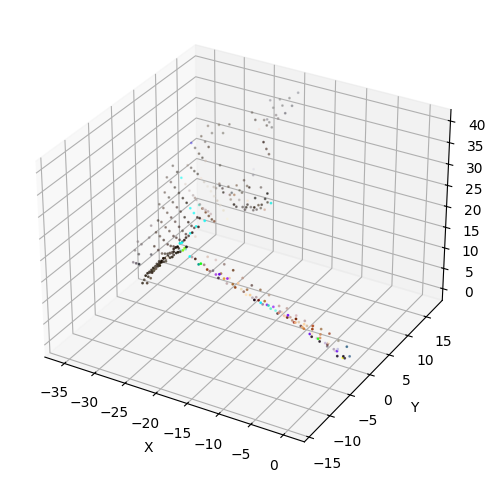

In [104]:

# colors to show in rerun
rgb_array = (get_rgb_at_coords_torch(video_tensor_original[0, 0, :].permute(2, 0, 1), reconstructed_obs[0:2, :].T)*255).to(torch.uint8)
colors = [rgba_to_rgba32(*rgb_array[i, :].tolist(), 255) for i in range(rgb_array.shape[0])]

#plt.figure(figsize=(12, 6))
#plt.imshow(reconstructed_obs, aspect='auto', cmap='gray')

# it actually works

# make a 3d plot with matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(shape[0, :].cpu(), shape[1, :].cpu(), shape
[2, :].cpu(), c=rgb_array.numpy() / 255, s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


In [56]:


import time
start = time.time()

(get_rgb_at_coords_torch( video_tensor_original[0, 0, :].permute(2, 0, 1), reconstructed_obs[0:2, 0:2] ) *255)

print("Time taken:", time.time() - start)

Time taken: 0.0006389617919921875


In [ ]:
A = torch.randn(2,2, requires_grad=True)
print(A)
norm_fro = torch.norm(A, p='fro')      # Frobenius norm
print("\n")

# Choose one to backpropagate
loss = norm_fro  # or norm_1, norm_inf, norm_2

# Backward pass
loss.backward()

# Gradient of A is now available
print(A.grad)


tensor([[ 0.2725, -0.0139],
        [ 1.2516, -0.1911]], requires_grad=True)


tensor([[ 0.2104, -0.0107],
        [ 0.9664, -0.1476]])
